In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV



In [3]:
file_path = 'C:\\Users\\Asus\\Downloads\\finance.csv'
df = pd.read_csv(file_path)
df = df.dropna() 
df['Year'] = df['Year'].astype(int)

In [5]:
df = pd.get_dummies(df, columns=['Sector'], drop_first=True)

In [7]:
df['Asst/Shr'] = df['Asst/Shr'].apply(lambda x: x if x > 0 else np.nan)
df = df.dropna(subset=['Asst/Shr']) 


df['PE_DivYield'] = df['PE'] * df['Div.Yield']  
df['Log_AsstShr'] = np.log1p(df['Asst/Shr'])    


In [9]:
numeric_features = ['Eps', 'PE', 'Asst/Shr', 'Profit', 'Divid%', 'Div.Yield', 'PE_DivYield', 'Log_AsstShr']
scaler = MinMaxScaler()
df[numeric_features] = scaler.fit_transform(df[numeric_features])

In [11]:
X = df.drop(columns=['Symbol', 'Divid%'])
y = df['Divid%']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)

Training set size: (2062, 26)
Test set size: (516, 26)


In [13]:

linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_linear = linear_model.predict(X_test)
rmse_linear = np.sqrt(mean_squared_error(y_test, y_pred_linear))
r2_linear = r2_score(y_test, y_pred_linear)


decision_tree_model = DecisionTreeRegressor()
decision_tree_model.fit(X_train, y_train)
y_pred_tree = decision_tree_model.predict(X_test)
rmse_tree = np.sqrt(mean_squared_error(y_test, y_pred_tree))
r2_tree = r2_score(y_test, y_pred_tree)


random_forest_model = RandomForestRegressor()
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_features': ['sqrt', 'log2', None], 
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search_rf = RandomizedSearchCV(
    estimator=random_forest_model, 
    param_distributions=param_grid_rf,
    n_iter=10, 
    cv=3, 
    n_jobs=-1, 
    verbose=1, 
    random_state=42
)

grid_search_rf.fit(X_train, y_train)

best_rf_model = grid_search_rf.best_estimator_
y_pred_rf = best_rf_model.predict(X_test)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)



Fitting 3 folds for each of 10 candidates, totalling 30 fits


In [14]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X_train)  

linear_model.fit(X_poly, y_train)
y_pred_linear = linear_model.predict(poly.transform(X_test))

rmse_linear = np.sqrt(mean_squared_error(y_test, y_pred_linear))
r2_linear = r2_score(y_test, y_pred_linear)



In [17]:
from sklearn.model_selection import GridSearchCV

param_grid_dt = {
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search_dt = GridSearchCV(estimator=decision_tree_model, param_grid=param_grid_dt,
                              cv=3, n_jobs=-1, verbose=1)

grid_search_dt.fit(X_train, y_train)
best_dt_model = grid_search_dt.best_estimator_

y_pred_tree = best_dt_model.predict(X_test)
rmse_tree = np.sqrt(mean_squared_error(y_test, y_pred_tree))
r2_tree = r2_score(y_test, y_pred_tree)


Fitting 3 folds for each of 45 candidates, totalling 135 fits


In [19]:

metrics = {}
metrics['Linear Regression'] = {
    'RMSE': rmse_linear,
    'R^2': r2_linear,
    'MAE': mean_absolute_error(y_test, y_pred_linear)
}

metrics['Decision Tree'] = {
    'RMSE': rmse_tree,
    'R^2': r2_tree,
    'MAE': mean_absolute_error(y_test, y_pred_tree)
}

metrics['Random Forest'] = {
    'RMSE': rmse_rf,
    'R^2': r2_rf,
    'MAE': mean_absolute_error(y_test, y_pred_rf)
}

for model_name, model_metrics in metrics.items():
    print(f"\n{model_name}:")
    for metric, value in model_metrics.items():
        print(f"{metric}: {value:.4f}")



Linear Regression:
RMSE: 0.0352
R^2: 0.5882
MAE: 0.0062

Decision Tree:
RMSE: 0.0282
R^2: 0.7355
MAE: 0.0061

Random Forest:
RMSE: 0.0244
R^2: 0.8028
MAE: 0.0048


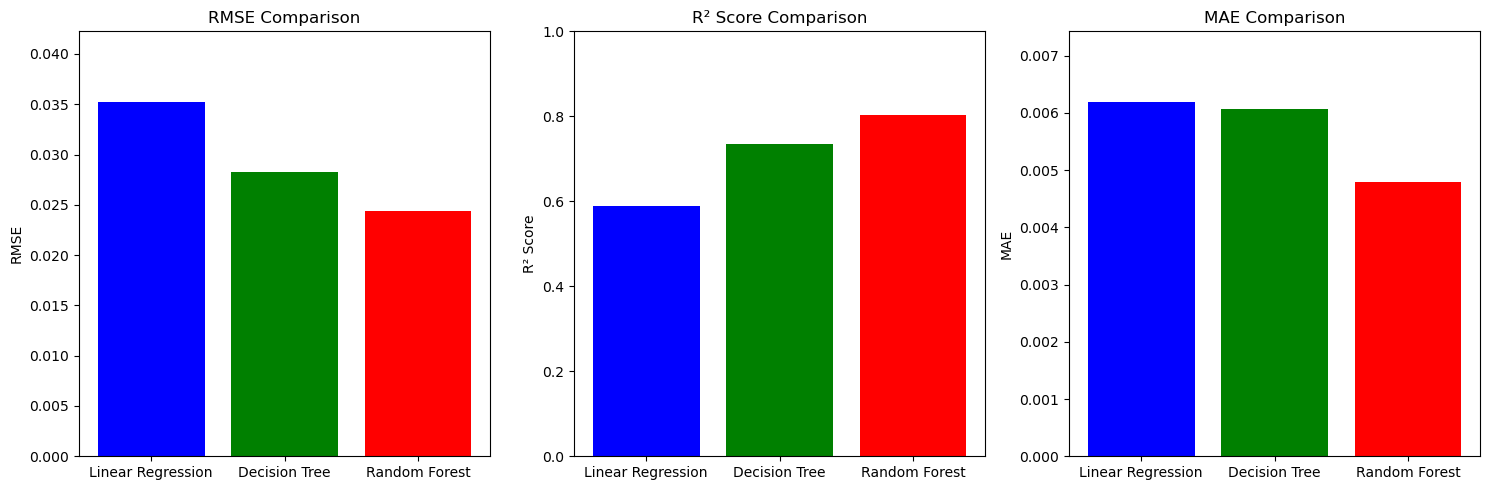

In [21]:


mae_linear = mean_absolute_error(y_test, y_pred_linear)
mae_tree = mean_absolute_error(y_test, y_pred_tree)
mae_rf = mean_absolute_error(y_test, y_pred_rf)

metrics = {
    'Linear Regression': {'RMSE': rmse_linear, 'R2': r2_linear, 'MAE': mae_linear},
    'Decision Tree': {'RMSE': rmse_tree, 'R2': r2_tree, 'MAE': mae_tree},
    'Random Forest': {'RMSE': rmse_rf, 'R2': r2_rf, 'MAE': mae_rf}
}

models = list(metrics.keys())
rmse_values = [metrics[model]['RMSE'] for model in models]
r2_values = [metrics[model]['R2'] for model in models]
mae_values = [metrics[model]['MAE'] for model in models]

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# RMSE
ax[0].bar(models, rmse_values, color=['blue', 'green', 'red'])
ax[0].set_title('RMSE Comparison')
ax[0].set_ylabel('RMSE')
ax[0].set_ylim(0, max(rmse_values) * 1.2)

# R² Score
ax[1].bar(models, r2_values, color=['blue', 'green', 'red'])
ax[1].set_title('R² Score Comparison')
ax[1].set_ylabel('R² Score')
ax[1].set_ylim(0, 1)  # R² range is between 0 and 1

# MAE
ax[2].bar(models, mae_values, color=['blue', 'green', 'red'])
ax[2].set_title('MAE Comparison')
ax[2].set_ylabel('MAE')
ax[2].set_ylim(0, max(mae_values) * 1.2)

plt.tight_layout()
plt.show()


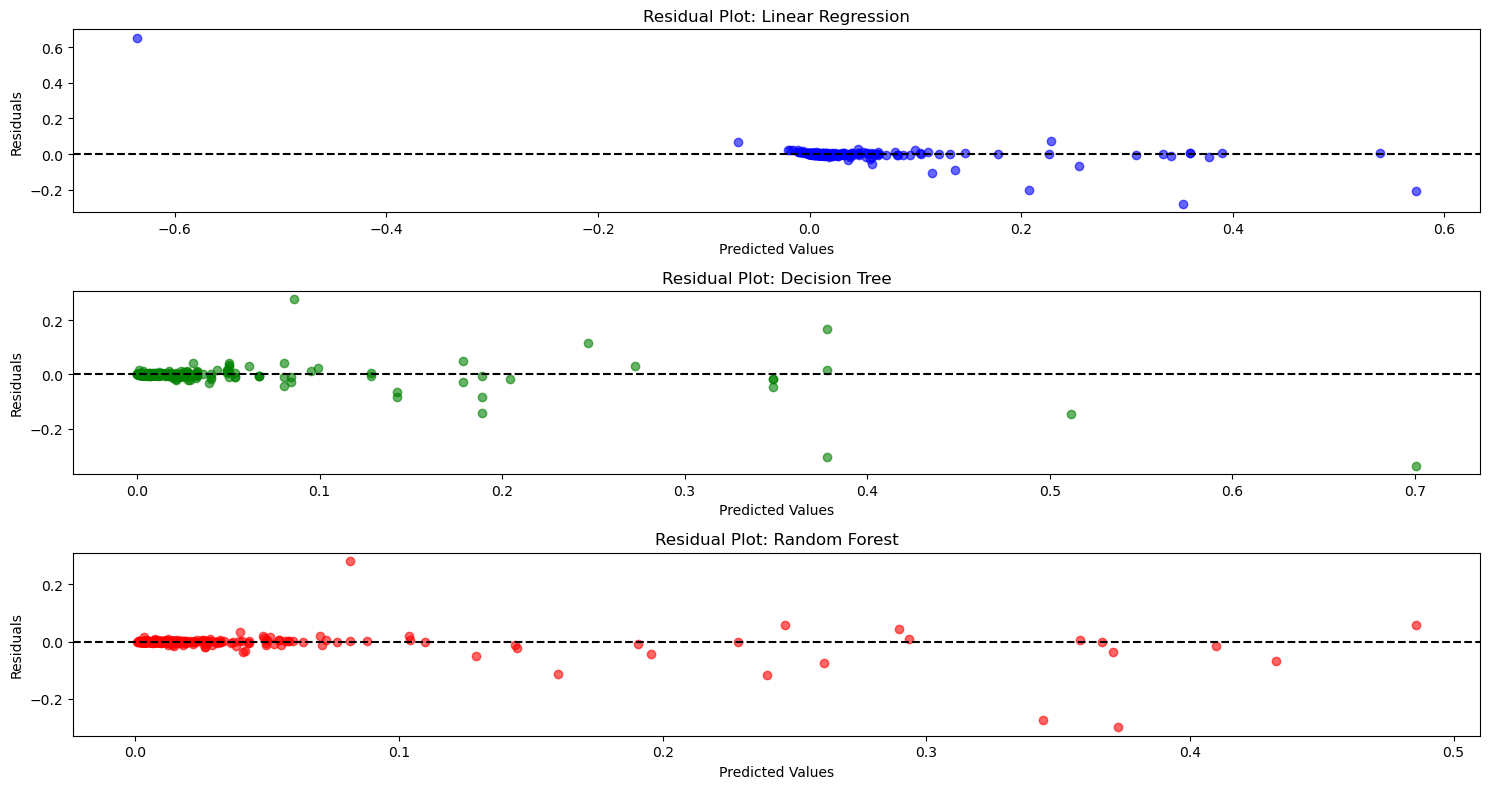

In [23]:

residuals_linear = y_test - y_pred_linear
residuals_tree = y_test - y_pred_tree
residuals_rf = y_test - y_pred_rf

plt.figure(figsize=(15, 8))

# Residual plot for Linear Regression
plt.subplot(3, 1, 1)
plt.scatter(y_pred_linear, residuals_linear, color="blue", alpha=0.6)
plt.axhline(y=0, color='black', linestyle='--')
plt.title("Residual Plot: Linear Regression")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")

# Residual plot for Decision Tree
plt.subplot(3, 1, 2)
plt.scatter(y_pred_tree, residuals_tree, color="green", alpha=0.6)
plt.axhline(y=0, color='black', linestyle='--')
plt.title("Residual Plot: Decision Tree")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")

# Residual plot for Random Forest
plt.subplot(3, 1, 3)
plt.scatter(y_pred_rf, residuals_rf, color="red", alpha=0.6)
plt.axhline(y=0, color='black', linestyle='--')
plt.title("Residual Plot: Random Forest")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")


plt.tight_layout()
plt.show()